 the purpose of this short notebook is just to examine how velocities are calculated and
 why large velocities of 2 or 3 $\mu m/s$ are reported in analysis

In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import readtrack
import command
import pilush
import plotutils
plotutils.default_style()


In [2]:
# datapaths
testdata = "/home/dan/usb_twitching/run/c450a32/two_parameters_koch/pilivar_0050.00000_k_spawn_10.00000/testview/trackxy.dat"

tr = readtrack.Track(testdata)


In [3]:

# head velocity
def _displacement(tr):
    xy = np.column_stack([tr['x'], tr['y']])
    dxy = xy[1:] - xy[:-1]
    disp = np.linalg.norm(dxy,axis=1)
    dt = tr['time'][1:] - tr['time'][:-1]
    return xy, dxy, disp, dt
xy, dxy, disp, dt = _displacement(tr)
# vel =  / dt[:,np.newaxis]
print('timesteps are in range ', np.min(dt), np.max(dt))
print('displacements are in range ', np.min(disp), np.max(disp))

timesteps are in range  0.030210325400000015 0.10328533179999999
displacements are in range  0.0 0.27205445030875847


In [4]:
# smallest dt is 0.03 but this is just the first step because of a small bug
print('minimum dt after first step ', np.min(dt[1:]))


minimum dt after first step  0.09564547309999993


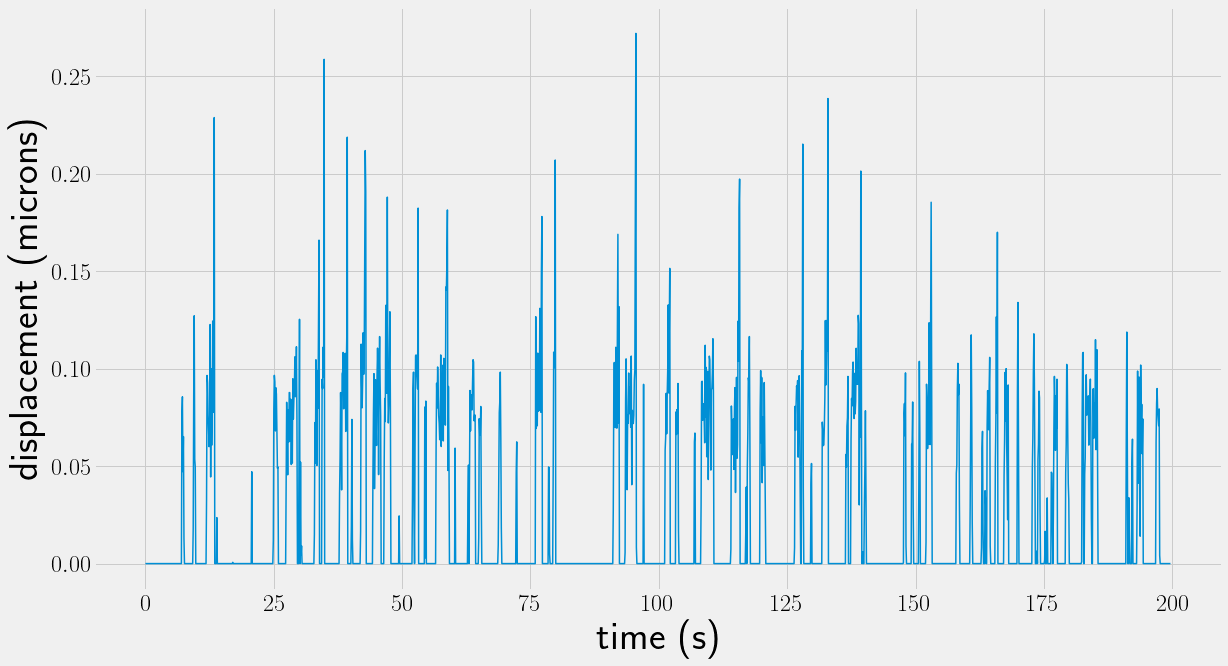

In [5]:
# show the displacment profile
ax = plt.gca()
plt.plot(np.cumsum(dt), disp)
ax.set_xlabel('time (s)')
ax.set_ylabel('displacement (microns)')
plt.show()

In [6]:
def print_axis(arr):
    return '({:.3f}, {:.3f}, {:.3f})'.format(*arr)

# largest displacement is 0.27 which means velocity of 2.7 \mu m/s
# lets investigate those large displacements in detail
sort_idx = np.argsort(disp)
l_idx = sort_idx[-1]
print('largest displacement occurs at time {}s'.format( tr['time'][l_idx]) )
print('displacement {} -> {}'.format(xy[l_idx], xy[l_idx+1]))
axis = tr.get_frame()[1]
print('body axis {} -> {}'.format(print_axis(axis[l_idx]), print_axis(axis[l_idx+1])))
# lets decompose this displacement along the initial axis
thisdxy = dxy[l_idx]
primary_ax = axis[l_idx][:2]
FLOAT_TOL = 1e-6
assert(np.linalg.norm(primary_ax) - 1.0 < FLOAT_TOL)
primary_dx = np.dot(primary_ax, thisdxy) * primary_ax
print('this displacment', thisdxy)
sec_dx = thisdxy - primary_dx
print('after decomposing along the body axis:\n', primary_dx , sec_dx)



largest displacement occurs at time 95.8001593676s
displacement [21.02135177  1.7527593 ] -> [21.27734907  1.84484082]
body axis (0.951, 0.309, -0.000) -> (0.965, 0.263, -0.000)
this displacment [0.2559973  0.09208152]
after decomposing along the body axis:
 [0.25863114 0.0839691 ] [-0.00263384  0.00811242]


 We find (surprising) that this large displacement is not due to a rotation
 so we need to rethink what can cause such a large displacement.
 In order to make progress we need a full output, not just 0.1s resolution data

In [7]:
highresdir = "/home/dan/usb_twitching/run/c450a32/two_parameters_koch/pilivar_0050.00000_k_spawn_10.00000/testview/highres/"
highresdata = os.path.join(highresdir,"trackxy.dat")
with command.loadexplain('tracking data'):
    htr = readtrack.Track(highresdata)
with command.loadexplain('pili data'):
    with command.chdir(highresdir):
        ptdata = readtrack.piliset()[0]


loading tracking data...
finished loading tracking data.
loading pili data...
found pilitracking.dat file
finished loading pili data.


In [8]:
print('reorganise pili data by pilus')
pilusdata = pilush.reorganise(ptdata)
print('finished.')


reorganise pili data by pilus
finished.


In [9]:
# first thing to do is find out if we can get the same large displacements as before
resolution = 0.1
htr.true_filter_to_resolution(resolution)
# since this is a new implementation of the resolution filtering method we make a short aside here to test it
assert(htr.slice[0] != htr.slice[1])
def test_filter(tr):
    xy, dxy, disp, dt = _displacement(htr)
    sort_idx = np.argsort(disp)
    l_idx = sort_idx[-1]
    print('largest displacement occurs at time {}s'.format( tr['time'][l_idx]) )
    print('displacement {} -> {}'.format(xy[l_idx], xy[l_idx+1]))
    return htr.slice[sort_idx]

print("Sanity check that after full output and setting resolution we recover the same result")
sort_idx = test_filter(htr)
# Sanity Check commplete


Sanity check that after full output and setting resolution we recover the same result
largest displacement occurs at time 95.8001593676s
displacement [21.02135177  1.7527593 ] -> [21.27734907  1.84484082]


In [10]:
# Examine the retraction events during this displacement
htr.clear_filter()
time = htr['time']
l_idx = sort_idx[-1]
l_idx1 = np.searchsorted(time, time[l_idx]+0.1)
print('there are {} MC steps between {:.3f} and {:.3f}'.format(
    l_idx1-l_idx, time[l_idx], time[l_idx1]))
print('npili is {:.3f}'.format( np.mean(htr['npili'][l_idx:l_idx1])))
nbound = np.mean(htr['nbound'][l_idx:l_idx1])
print('nbound is {}, (min,max) = ({},{})'.format(
    nbound, np.min(nbound), np.max(nbound)))
# so the binding number doesn't change
l_process = htr['process'][l_idx:l_idx1]
from collections import Counter
proc = Counter(l_process)
print('processes', proc)
# to examine the pili behvaiour we need load the event or pili data

there are 354 MC steps between 95.800 and 95.900
npili is 33.441
nbound is 2.0, (min,max) = (2.0,2.0)
processes Counter({'retraction': 222, 'extension': 128, 'resample': 3, 'spawn': 1})


In [11]:
# ptdata only includes bound pili (by default)
context, lpt = ptdata[l_idx]
start_time, end_time = time[l_idx], time[l_idx1]
print('context', context)
boundpidx = lpt['pidx']
print("so bound pili during large displacement are ", boundpidx)
for pidx in boundpidx:
    print('for pilus ', pidx)
    pdata = pilusdata[pidx]
    t = pdata['time']

    leq = pdata['pleq']; plength = pdata['plength']
    start_idx, end_idx = np.searchsorted(t, start_time),np.searchsorted(t,end_time)
    dl = leq[start_idx] - leq[end_idx]
    nret = int(dl//0.004)
    print('number of retractions {:d}, thats {:d}/s'.format(nret, int(nret/0.1)))
    bounddl = plength[start_idx] - plength[end_idx]
    print('length {:.4f} -> {:.4f}'.format(leq[start_idx], leq[end_idx]))
    print('leq change is {:.4f}, bound length change is {:.4f}'.format(dl, bounddl))
    print()
# so how is is that the body displaces by ~0.27?
# the retraction rate is set to ~187.5

context (95.8001593676, 33)
so bound pili during large displacement are  [725 785]
for pilus  725
number of retractions 16, thats 160/s
length 0.7323 -> 0.6683
leq change is 0.0640, bound length change is 0.0594

for pilus  785
number of retractions 21, thats 210/s
length 0.5750 -> 0.4870
leq change is 0.0880, bound length change is 0.0817



In [12]:
# might want to pull out the retraction events from the tracking data 
# but tracking data seems to be missing pidx column ...


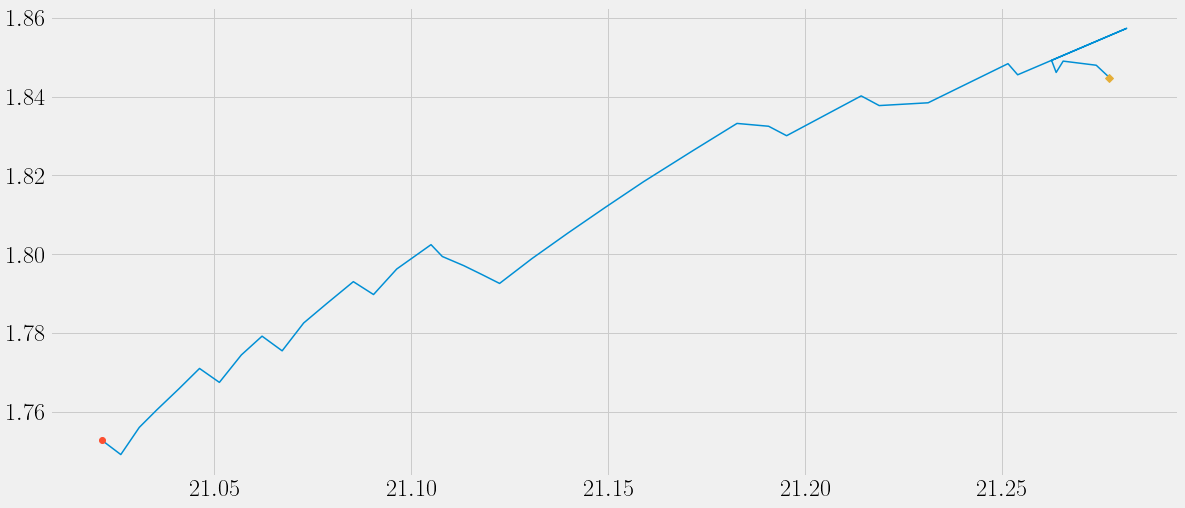

In [13]:
# lets plot the trajectory
ax = plt.gca()
x, y = htr['x'][l_idx:l_idx1], htr['y'][l_idx:l_idx1]
ax.plot(x, y)
ax.plot(x[0], y[0], marker='o')
ax.plot(x[-1], y[-1], marker='D')

ax.set_aspect('equal')
plt.show()
# displacement [21.02135177  1.7527593 ] -> [21.27734907  1.84484082]


# # %%
# ax = plt.gca()
# for pidx in boundpidx:
#     pdata = pilusdata[pidx]
#     leq = pdata['pleq']
#     ax.plot(pdata['time'], leq)
#     ax.set_ylabel('length')
# ax.set_xlim((time[l_idx]-0.05,time[l_idx1]+0.05))
# ax.set_ylim((0,2.0))
# plt.show()
